# 6.10.1 Baseband Pulseshaping and Eye Diagrams
<span style="color:red"> <b>*Note: Need to install commpy via *</b></span>
``` bash
pip install scikit-commpy
```


In [3]:
!pip install scikit-commpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 2.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-commpy: filename=scikit_commpy-0.8.0-py3-none-any.whl size=115007 sha256=1f2e895c1aa5d0235337f1258c592df26645af96394e9eaa345795ea109c9bab
  Stored in directory: /root/.cache/pip/wheels/36/eb/56/f0bffa07ed968244dac624cfc6dee75474b7b451299bf54950
Successfully built scikit-commpy


In [4]:
import numpy as np
from commpy.filters import rrcosfilter
from commpy.filters import rcosfilter
import matplotlib.pyplot as plt
from scipy.signal import welch,get_window

In [6]:
def pnrz(T):
    # generating a rectangular pulse of width T
    # Usage: pout = pnrz(T)
    return np.ones(T)

def prz(T):
    # generating a rectangular pulse of width T/2
    # Usage: pout = prz(T)
    return np.concatenate((np.zeros(T//4), np.ones(T//2), np.zeros(T//4)))

def psine(T):
    # generating a sinusoid pulse of width T
    # Usage: pout = psine(T)
    return np.sin(np.pi * np.arange(T) / T)

def rcosfir(r, N_T=3, rate=5, T=1, fil_type='normal', col='b'):
    # Check input variables
    if (r < 0) or (r > 1) or not np.isreal(r):
        raise ValueError("Rolloff factor in RCOSFIR must be in the range, [0, 1].")
    if type(N_T) == int:
        N_T = [-abs(N_T), N_T]
    elif len(N_T) < 2:
        N_T = [-abs(N_T[0]), N_T[0]]
    if (rate <= 1) or (rate != int(rate)):
        raise ValueError("RATE in RCOSFIR must be an integer greater than 1")
    # Calculate filter coefficients of a raised cosine filter
    b = rcosfilter(rate*(N_T[1]-N_T[0])+1, alpha=r, Ts=rate, Fs=1)[1]
    return b

def prcos(rollfac, length, T):
    # Usage: y = prcos(rollfac, length, T)
    # rollfac = 0 to 1 is the rolloff factor
    # length is the one-sided pulse length in the number of T
    # length = 2T+1;
    # T is the oversampling rate
    return rcosfir(r=rollfac, N_T=length, rate=T, T=1, fil_type='normal')

# Save this block below as eyeplot.py
def eyeplot(onedsignal, Npeye, NsampT, Toffset):
    """This function plots the eye diagram of the input signal string.
    Args:
    onedsignal: input signal string for eye diagram plot.
    Npeye: number of horizontal T periods for the eye diagram.
    NsampT: number of samples in each baud period Tperiod.
    Toffset: eye diagram offset in fraction of symbol period.
    Returns:
    eyesuccess: set to 1 to indicate success. """
    Noff = int(np.floor(Toffset * NsampT))          # offset in samples
    Leye = np.arange(1, Npeye*NsampT+1) / NsampT    # x-axis
    Lperiod = int((len(onedsignal)-Noff) // (Npeye*NsampT))
    Lrange = range(Noff, Noff+Lperiod*Npeye*NsampT)
    mdsignal = np.reshape(onedsignal[Lrange], [Npeye*NsampT, Lperiod], order='F')
    plt.plot(Leye, mdsignal, 'b')    # Use blue color
    return 1        # return 1 as success indicator

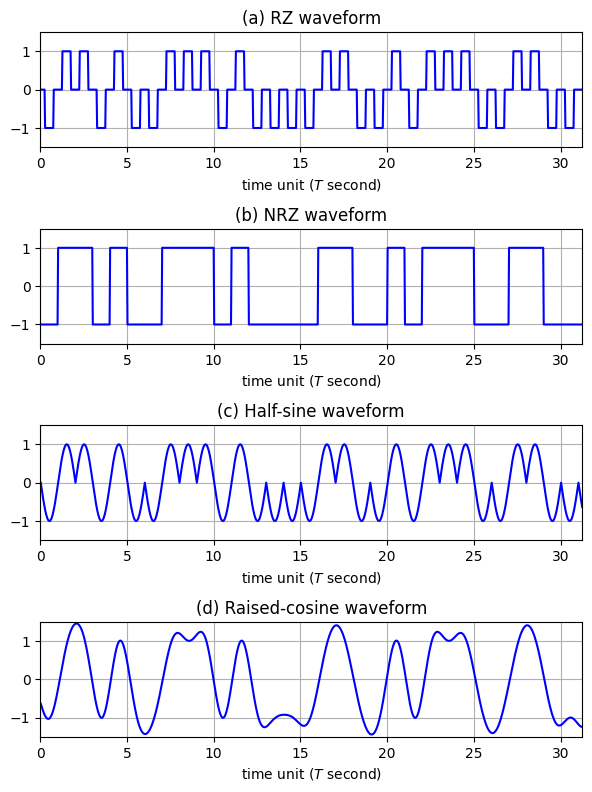

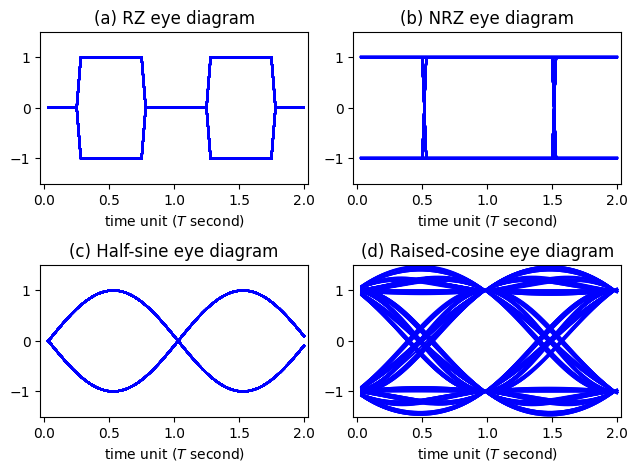

In [15]:
# Generate 400 random bits
data = np.sign(np.random.randn(1, 400))
Tau = 32        # Define the symbol period
Tped = 0.001    # True symbol period Tped in second
dataup = np.stack([data]+[data*0]*(Tau-1),axis=-1).reshape(-1) # Generate impulse train

yrz = np.convolve(dataup, prz(Tau))       # Return to zero polar signal
yrz = yrz[:-Tau+1]                        # Remove trailing samples
ynrz = np.convolve(dataup, pnrz(Tau))     # Non-return to zero polar
ynrz = ynrz[:-Tau+1]                      # Remove trailing samples
ysine = np.convolve(dataup, psine(Tau))   # Half sinusoid polar
ysine = ysine[:-Tau+1]                    # Remove trailing samples
Td = 4                                    # Truncating raised cosine to 4 periods
rollfac = 0.5                             # SET Rolloff factor, e.g.  0.5
# Generating RC pulse train
yrcosa = np.convolve(dataup, prcos(rollfac, Td, Tau))
yrcos = np.convolve(yrcosa,prcos(rollfac, Td, Tau))/Tau
yrcos = yrcos[(2*Td*Tau - Tau//2 - 1):-3*Td*Tau]  # Remove trailing samples
yrcosa = yrcosa[(Td*Tau - Tau//2 - 1):-2*Td*Tau]
txis = np.arange(1, 1001) / Tau           # Time axis

fig1 = plt.figure(figsize =(6, 8)); fig1.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(411)
w1 = plt.plot(txis,yrz[:1000],'b'); plt.title('(a) RZ waveform')
plt.axis([0, 1000/Tau, -1.5, 1.5]); plt.xlabel(r'time unit ($T$ second)')
plt.grid();plt.subplot(412)
w2 = plt.plot(txis,ynrz[:1000],'b'); plt.title('(b) NRZ waveform')
plt.axis([0, 1000/Tau, -1.5, 1.5]); plt.xlabel(r'time unit ($T$ second)')
plt.grid(); plt.subplot(413)
w3 = plt.plot(txis,ysine[:1000],'b'); plt.title('(c) Half-sine waveform')
plt.axis([0, 1000/Tau, -1.5, 1.5]); plt.xlabel(r'time unit ($T$ second)')
plt.grid(); plt.subplot(414)
w4 = plt.plot(txis,yrcosa[:1000],'b'); plt.title('(d) Raised-cosine waveform')
plt.axis([0, 1000/Tau, -1.5, 1.5]); plt.xlabel(r'time unit ($T$ second)')
plt.tight_layout(pad=1.0)   # Set the spacing between subfigures
plt.grid();  plt.show()

Nwidth=2    #  Now start Eye-diagram by setting width in units of T
edged=1/Tau #  Make viewing window slightly wider
fig2 = plt.figure(); fig2.subplots_adjust(hspace=0.5,wspace=0.4)

plt.subplot(221);
eye1=eyeplot(yrz,Nwidth,Tau,0); plt.title('(a) RZ eye diagram')
plt.axis([-edged, Nwidth+edged, -1.5, 1.5]); plt.xlabel(r'time unit ($T$ second)')
plt.subplot(222)
eye2=eyeplot(ynrz,Nwidth,Tau,0.5); plt.title('(b) NRZ eye diagram')
plt.axis([-edged, Nwidth+edged, -1.5, 1.5]); plt.xlabel(r'time unit ($T$ second)')
plt.subplot(223)
eye3=eyeplot(ysine,Nwidth,Tau,0); plt.title('(c) Half-sine eye diagram')
plt.axis([-edged, Nwidth+edged, -1.5, 1.5]); plt.xlabel(r'time unit ($T$ second)')
plt.subplot(224)
eye4=eyeplot(yrcosa,Nwidth,Tau,3*edged+0.5); plt.title('(d) Raised-cosine eye diagram')
plt.axis([-edged, Nwidth+edged, -1.5, 1.5]); plt.xlabel(r'time unit ($T$ second)')

# Set the spacing between subfigures
plt.tight_layout(pad=1.0); plt.show()

<img src="images/Fig6_39.png" width="600" />

<center><b>Figure 6.39</b> Baseband modulation signals using the following pulse shapes: (a) half-width RZ rectangular pulse; (b) half-sine pulse; (c) raised-cosine pulse with roll-off factor of 0.5.</center>

<img src="images/Fig6_40.png" width="600" />

<center><b>Figure 6.40</b> Eye diagrams of binary polar baseband modulation waveforms using (a) Half-width rectangular RZ pulse; (b) Rectangular NRZ pulse with half-symbol offset; (c) Half-sine pulse; (d) Raised cosine pulse with rolloff factor of 0.5.</center>

<span style="color:red"> <b>*Note: the plots below doesn't look like Fig.6.29 as stated in the book. But MATLAB and Python code give same results.*</b></span>

> *The second program (Mary_eye.m) uses the four different pulses to generate eye diagrams of four-level PAM signaling of Fig. 6.29.*

<img src="images/Fig6_29.png" width="600" />

<center><b>Figure 6.29</b> in the book</center>


Text(0.5, 1.0, 'Raised-cosine eye diagram')

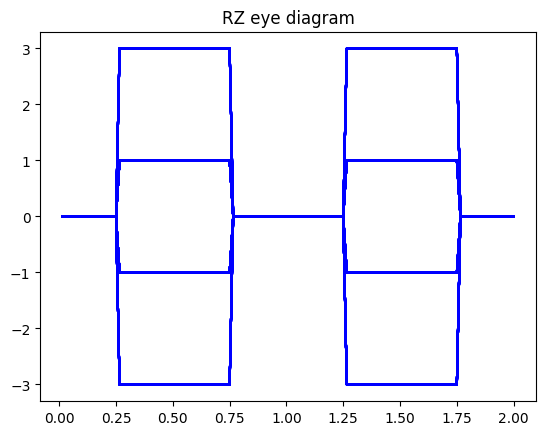

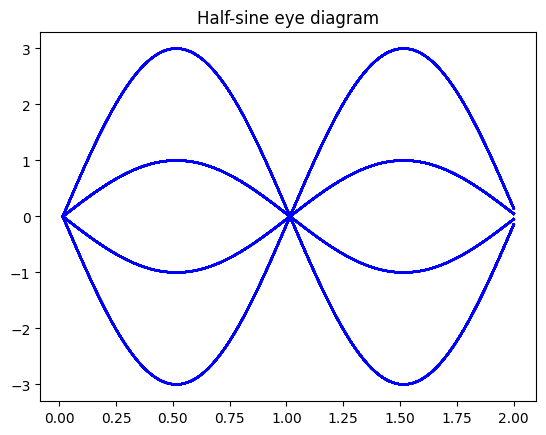

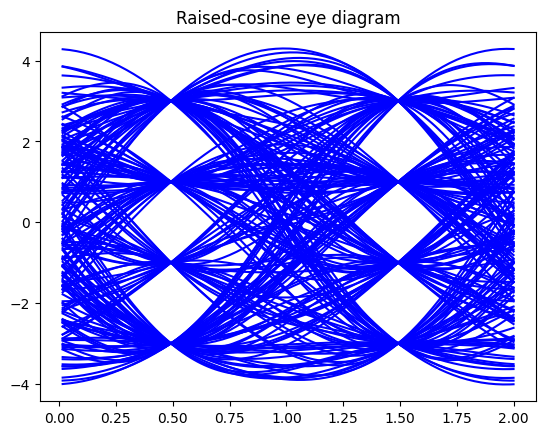

In [8]:
# Save this codeblock as Mary_eye.py
# Generate 400 PAM symbols
data = np.sign(np.random.randn(1, 400)) + 2 * np.sign(np.random.randn(1, 400))
Tau = 64              # Define the symbol period
dataup = np.stack([data] +[data*0] * (Tau-1),axis=-1).reshape(-1) # impulse train

yrz = np.convolve(dataup, prz(Tau))   # Return to zero polar pulse
yrz = yrz[:len(yrz)-Tau+1]
ysine = np.convolve(dataup, psine(Tau)) # Half sinusoid pulse
ysine = ysine[:len(ysine)-Tau+1]

Td=4; # truncating raised cosine to 4 periods
yrcos = np.convolve(dataup, prcos(0.5, Td, Tau))  # Roll-off factor = 0.5
yrcos = yrcos[2 * 4 * Tau:len(yrcos)-2 * 4 * Tau + 1] # generating RC pulse train

plt.figure(); eye1=eyeplot(yrz,Nwidth,Tau,0); plt.title('RZ eye diagram')

plt.figure(); eye3=eyeplot(ysine,Nwidth,Tau,0); plt.title('Half-sine eye diagram')

plt.figure(); eye4=eyeplot(yrcos,Nwidth,Tau,edged+0.5); plt.title('Raised-cosine eye diagram')

# 6.10.2 PSD Estimation
<span style="color:red"> <b>*Note: See Textbook.*</b></span>


In [17]:
# Save the code block as PSDplot.py
# This example generates and plots power spectra of baseband data modulations.
Nd = 8000  # Number of bits in PAM
data = np.sign(np.random.randn(Nd))  # Generate Nd random bits
Tau = 16  # Define the symbol period in samples
T = 1e-3  # symbol period in real time (second)
Tped = 0.001  # true symbol period Tped in second

dataup = np.stack([data] +[data*0] * (Tau-1),axis=-1).reshape(-1) # impulse train

yrz = np.convolve(dataup, prz(Tau))   # Return to zero polar pulse
yrz = yrz[:len(yrz)-Tau+1]
ynrz = np.convolve(dataup, pnrz(Tau))   # Not Return to zero polar pulse
ynrz = ynrz[:len(yrz)-Tau+1]
ysine = np.convolve(dataup, psine(Tau)) # Half sinusoid pulse
ysine = ysine[:len(ysine)-Tau+1]

Td=4; # truncating raised cosine to 4 periods
yrcos = np.convolve(dataup, prcos(0.5, Td, Tau))  # Roll-off factor = 0.5
yrcos = yrcos[2*4*Tau:len(yrcos)-2*4*Tau + 1] # generating RC pulse train

# Autocorrelation estimate for rcos
Cor1 = np.correlate(yrcos, yrcos,'full')[len(yrcos)-1-50:len(yrcos)+50]/len(yrcos)
# Autocorrelation estimate for RZ
Cor2 = np.correlate(yrz, yrz,'full')[len(yrz)-1-50:len(yrz) +50]/len(yrz)
# Autocorrelation estimate for NRZ
Cor3 = np.correlate(ynrz, ynrz,'full')[len(ynrz)-1-50:len(ynrz)+50]/len(ynrz)

In [18]:
fovsamp = Tau
Nfft = 1024  # range of frequency in units of 1/T
Hamming_W = get_window('hamming', np.floor(len(yrcos)/4.5).astype(int))

[frq, PSD1]=welch(yrcos,fs=1,window=Hamming_W, nfft=None, scaling='density',
                  return_onesided=0,detrend=0);   PSD1 /= fovsamp
[frq, PSD2]=welch(yrz,fs=1,window=Hamming_W,nfft=None,scaling='density',
                  return_onesided=0,detrend=0);   PSD2 /= fovsamp
[frq, PSD3]=welch(ynrz,fs=1,window=Hamming_W,nfft=None,scaling='density',
                  return_onesided=0,detrend=0);   PSD3 /= fovsamp
freqscale = np.fft.fftshift(frq*Tau)

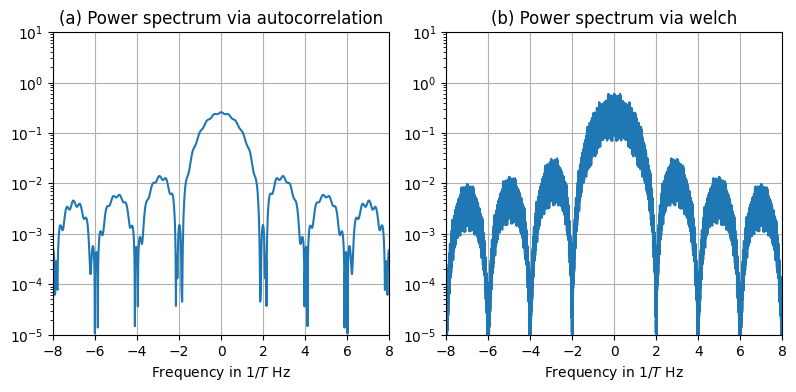

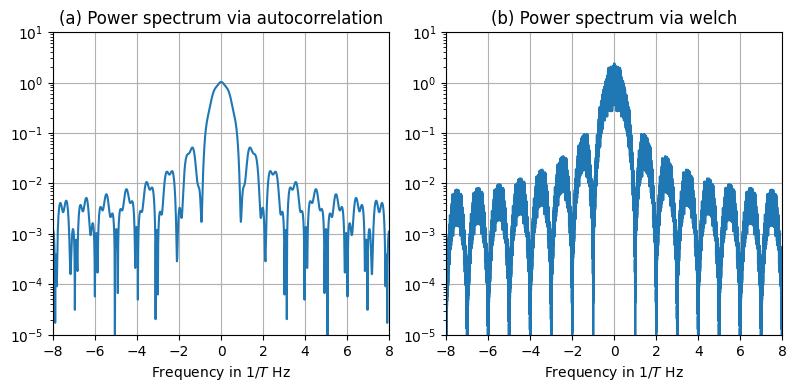

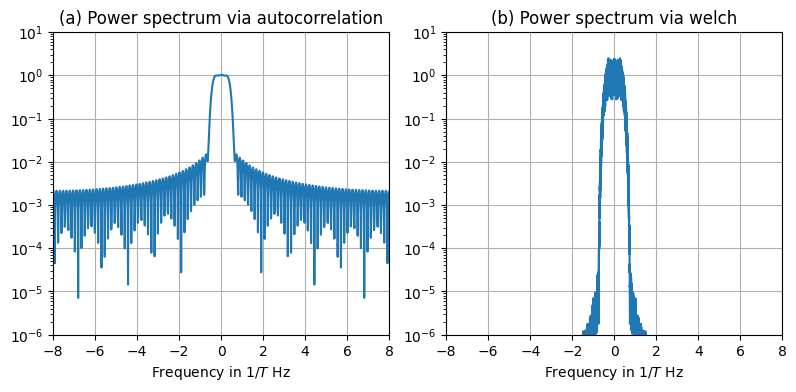

In [19]:
fig2 = plt.figure(figsize=(8,4));  fig2.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(121)
plt.semilogy(np.arange(Nfft)*(Tau/Nfft)-Tau/2,
             np.abs(np.fft.fftshift(np.fft.fft(Cor2,Nfft)/16)))
plt.title('(a) Power spectrum via autocorrelation'); plt.grid()
plt.axis([-Tau/2, Tau/2, 1.e-5, 1.e1]); plt.xlabel(r'Frequency in $1/T$ Hz')
plt.subplot(122)
plt.semilogy(freqscale,np.fft.fftshift(PSD2))
plt.title('(b) Power spectrum via welch'); plt.grid()
plt.axis([-Tau/2, Tau/2, 1.e-5, 1.e1]); plt.xlabel(r'Frequency in $1/T$ Hz')
plt.tight_layout(pad=1.0); plt.show()  # Set the spacing between subfigures

fig3 = plt.figure(figsize=(8,4));  fig3.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(121)
plt.semilogy(np.arange(Nfft)*(Tau/Nfft)-Tau/2,
             np.abs(np.fft.fftshift(np.fft.fft(Cor3,Nfft)/16)))
plt.title('(a) Power spectrum via autocorrelation'); plt.grid()
plt.axis([-Tau/2, Tau/2, 1.e-5, 1.e1]); plt.xlabel(r'Frequency in $1/T$ Hz')
plt.subplot(122)
plt.semilogy(freqscale,np.fft.fftshift(PSD3))
plt.title('(b) Power spectrum via welch'); plt.grid()
plt.axis([-Tau/2, Tau/2, 1.e-5, 1.e1]);  plt.xlabel(r'Frequency in $1/T$ Hz')
plt.tight_layout(pad=1.0); plt.show()  # Set the spacing between subfigures

fig1 = plt.figure(figsize=(8,4));  fig1.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(121)
plt.semilogy(np.arange(Nfft)*(Tau/Nfft)-Tau/2,
             np.abs(np.fft.fftshift(np.fft.fft(Cor1,Nfft)/16)))
plt.title('(a) Power spectrum via autocorrelation'); plt.grid()
plt.axis([-Tau/2, Tau/2, 1.e-6, 1.e1]); plt.xlabel(r'Frequency in $1/T$ Hz')
plt.subplot(122)
plt.semilogy(freqscale,np.fft.fftshift(PSD1))
plt.title('(b) Power spectrum via welch'); plt.grid()
plt.axis([-Tau/2, Tau/2, 1.e-6, 1.e1]); plt.xlabel(r'Frequency in $1/T$ Hz')
plt.tight_layout(pad=1.0); plt.show()  # Set the spacing between subfigures

<img src="images/Fig6_41.png" width="600" />

<center><b>Figure 6.41</b> Power spectral densities of binary polar baseband modulation using the half-width rectangular RZ pulse: (a) using autocorrelation method; (b) using Welch method of averaging periodograms. </center>

<img src="images/Fig6_42.png" width="600" />

<center><b>Figure 6.42</b> Power spectral densities of binary polar baseband modulation using the full-width rectangular NRZ pulse: (a) using autocorrelation method; (b) using Welch method of averaging periodograms.</center>

<img src="images/Fig6_43.png" width="600" />

<center><b>Figure 6.43</b> Power spectral densities of binary polar baseband modulation using the raised cosine pulse with roll-off factor of 0.5: (a) using autocorrelation method; (b) using Welch method of averaging periodograms.</center>
